#### Imports

In [2]:

import torch
import pandas as pd
import numpy as np
import torch.utils.data as data

#### Data set loading and initial processing

In [83]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

for val in df["quality"].unique():
    print(val, len(df.loc[df["quality"] == val])/len(df))

min_quality = 3
max_quality = 9

# one_hot = pd.get_dummies(df["quality"])
# df = df.drop("quality", axis=1)
# df = df.join(one_hot)

df["quality"] = (df["quality"] - min_quality) / (max_quality - min_quality)

features_cols = df.columns[:-1]

train = df.sample(frac=0.8, random_state=213)
test = df.drop(train.index)
valid = train.sample(frac=0.25, random_state=123)
train = train.drop(valid.index)

mean_value = train[features_cols].mean()
std_value = train[features_cols].std()
min_value = train[features_cols].min()
max_value = train[features_cols].max()

# standard scaling
train[features_cols] = (train[features_cols] - mean_value) / std_value
valid[features_cols] = (valid[features_cols] - mean_value) / std_value
test[features_cols] = (test[features_cols] - mean_value) / std_value

# min-max scaling
# train[features_cols] = (train[features_cols] - min_value) / (max_value - min_value)
# valid[features_cols] = (valid[features_cols] - min_value) / (max_value - min_value)
# test[features_cols] = (test[features_cols] - min_value) / (max_value - min_value)

# tanh estimator
# train[features_cols] = 0.5 * (np.tanh(0.01 * (train[features_cols] - mean_value) / std_value) + 1)
# valid[features_cols] = 0.5 * (np.tanh(0.01 * (valid[features_cols] - mean_value) / std_value) + 1)
# test[features_cols] = 0.5 * (np.tanh(0.01 * (test[features_cols] - mean_value) / std_value) + 1)

train

6 0.44875459371171905
5 0.2974683544303797
7 0.17966516945692118
8 0.03572886892609228
4 0.03327888934258881
3 0.004083299305839118
9 0.0010208248264597796


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
381,0.407735,0.007139,-0.613832,1.192840,0.015263,0.745247,0.949902,1.144836,-0.579315,0.254688,-1.233702,0.500000
2073,-0.292636,-0.090870,-0.359803,-0.215637,-0.031692,1.271472,1.184434,0.422593,0.798633,2.597109,-0.590190,0.333333
2883,-0.059179,1.918303,-0.021097,-0.479726,0.062218,-1.125776,-1.348520,-1.356752,0.273700,0.341444,2.305611,0.666667
679,-1.343192,0.399173,0.402285,-0.323229,-0.595151,-0.716490,-1.043627,-0.989065,1.520415,-0.612875,1.018588,0.666667
1915,0.407735,0.791206,0.232932,-0.137388,-0.360376,-0.541081,-0.949814,-0.857748,-1.694797,0.861982,1.581661,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.876278,-0.090870,0.825667,0.214731,0.156127,1.739228,2.450911,0.553910,-0.448082,-0.179094,-1.233702,0.333333
3084,-0.292636,-1.070954,0.148256,-0.743816,-0.736016,-0.131795,-1.418879,-0.838050,0.208084,1.989815,0.616394,0.500000
3289,-0.292636,0.007139,0.740991,0.351667,-0.078647,1.446880,1.348607,0.527646,-0.316849,-0.092337,-0.911946,0.333333
793,-1.109735,-0.384895,-0.275126,-0.861189,-0.595151,-0.424142,-1.090534,-0.578699,1.323566,1.729546,0.294638,0.666667


In [84]:
# train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-7]),torch.from_numpy(train.values[:,-7:]))
# valid_dataset = data.TensorDataset(torch.from_numpy(valid.values[:,:-7]),torch.from_numpy(valid.values[:,-7:]))
# test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,:-7]),torch.from_numpy(test.values[:,-7:]))

train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-1]),torch.from_numpy(train.values[:,-1]))
valid_dataset = data.TensorDataset(torch.from_numpy(valid.values[:,:-1]),torch.from_numpy(valid.values[:,-1]))
test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,:-1]),torch.from_numpy(test.values[:,-1]))

BATCH_SIZE = 128

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


#### Model

In [85]:
from typing import Callable
import torch.nn as nn
import torch.nn.functional as F

In [86]:
class SimpleMultiLayerNet(nn.Module):
    """
    What the name says
    """

    def __init__(
            self,
            input_size: int,
            output_size: int,
            activation: Callable | None = None,
            output_func: Callable | None = None,
            layers: list[int | float] | None = None
        ) -> None:
        super().__init__(

        )
        self.layers = nn.ModuleList([])
        self.last_layer: nn.Module
        self.activation: callable = activation
        self.output_func: callable = output_func

        in_size = input_size
        for layer_size in layers:
            if layer_size >= 1:
                self.layers.append(nn.Linear(in_features=in_size, out_features=layer_size))
                in_size = layer_size
            else:
                self.layers.append(nn.Dropout(layer_size))
        self.last_layer = nn.Linear(in_features=in_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x.float()
        for layer in self.layers:
            out = layer(out)
            if isinstance(layer, nn.Linear):
                out = self.activation(out)
        out = self.last_layer(out)
        return self.output_func(out) if self.output_func is not None else out
        

#### Trainer

In [87]:
class Trainer:
    """
    Class responsible for training the model
    """

    def __init__(
            self,
            model: nn.Module,
            optim: torch.optim.Optimizer,
            loss: Callable,
            train_dataloader: data.DataLoader,
            valid_dataloader: data.DataLoader,
            test_dataloader: data.DataLoader,
            metric: Callable,
            verbose: bool = True
        ):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = model.to(self.device)
        self.optim = optim
        self.loss = loss
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.metric = metric
        self.verbose = verbose
        self.history: list[tuple[float, float, float, float]] = []


    def evaluate(self, eval_dataloader: data.DataLoader) -> float:
        """
        Evlauates the model on given dataset
        """
        losses = []
        metric_scores = []
        self.model.eval()
        with torch.no_grad():
            for features, labels in eval_dataloader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(features).squeeze(dim=1)

                loss = self.loss(predictions, labels.float())
                losses.append(loss.item())
                metric_scores.append(self.metric(predictions, labels))
        return sum(losses) / len(losses), sum(metric_scores) / len(metric_scores)

    
    def train_one_epoch(self) -> None:
        """
        Trains one epoch
        """
        losses = []
        metric_scores = []
        self.model.train()
        for features, labels in self.train_dataloader:
            features = features.to(self.device)
            labels = labels.to(self.device)

            predictions = self.model(features).squeeze(dim=1)

            loss = self.loss(predictions, labels.float())

            self.optim.zero_grad()

            loss.backward()

            self.optim.step()

            losses.append(loss.item())
            metric_scores.append(self.metric(predictions, labels))
        self.history.append(
            (sum(losses)/len(losses), sum(metric_scores)/len(metric_scores), *self.evaluate(self.valid_dataloader))
        )
    
    def train(self, epochs: int, early_stoping: int = 0) -> None:
        """
        Trains model
        """
        min_loss = None
        without_progress = 0
        try:
            for epoch in range(epochs):
                self.train_one_epoch()
                if self.verbose is True:
                    train_loss, train_metric, valid_loss, valid_metric = self.history[-1]
                    print(
                        f"Epoch: {epoch}\t Train loss: {train_loss:.4}\t accuracy: {train_metric:.4}\t Validation loss: {valid_loss:.4}\t accuracy: {valid_metric:.4}"
                    )
                if early_stoping > 0:
                    _, _, valid_loss, _ = self.history[-1]
                    if min_loss is None:
                        min_loss = valid_loss
                    elif min_loss > valid_loss:
                        min_loss = valid_loss
                        without_progress = 0
                    else:
                        without_progress += 1
                    
                    if without_progress >= early_stoping:
                        break
        except KeyboardInterrupt:
            pass

        if self.verbose is True:
            test_loss, test_accuracy = self.evaluate(self.test_dataloader)
            print(f"Test loss: {test_loss:.4}\t accuracy: {test_accuracy:.4}")

#### Training

In [88]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [89]:
def accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    return float(torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1)) / len(labels))

def mse_accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    min_val = 3
    max_val = 9
    return float(torch.sum(torch.round(predictions * (max_val - min_val)) == labels * (max_val - min_val)) / len(labels))


In [90]:
# hyperparameters
IN_SIZE = 11
OUT_SIZE = 1
LAYERS = [512, 0.5, 256]
ACTIVATION = F.relu
OUTPUT_FUNC = None
LR = 0.003
EPOCHS = 1000
EARLY_STOPPING = 0

model = SimpleMultiLayerNet(
    input_size=IN_SIZE,
    output_size=OUT_SIZE,
    activation=ACTIVATION,
    output_func=OUTPUT_FUNC,
    layers=LAYERS
)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

trainer = Trainer(
    model=model,
    optim=optimizer,
    loss=loss,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    test_dataloader=test_dataloader,
    metric=mse_accuracy
)

trainer.train(epochs=EPOCHS, early_stoping=EARLY_STOPPING)

Epoch: 0	 Train loss: 0.06926	 accuracy: 0.2706	 Validation loss: 0.02418	 accuracy: 0.4096
Epoch: 1	 Train loss: 0.02669	 accuracy: 0.4098	 Validation loss: 0.02138	 accuracy: 0.4453
Epoch: 2	 Train loss: 0.02119	 accuracy: 0.4439	 Validation loss: 0.0203	 accuracy: 0.4591
Epoch: 3	 Train loss: 0.01935	 accuracy: 0.4826	 Validation loss: 0.01729	 accuracy: 0.5075
Epoch: 4	 Train loss: 0.01877	 accuracy: 0.473	 Validation loss: 0.01765	 accuracy: 0.4977
Epoch: 5	 Train loss: 0.01827	 accuracy: 0.4947	 Validation loss: 0.01799	 accuracy: 0.5031
Epoch: 6	 Train loss: 0.01743	 accuracy: 0.4964	 Validation loss: 0.0154	 accuracy: 0.5251
Epoch: 7	 Train loss: 0.01674	 accuracy: 0.5067	 Validation loss: 0.01873	 accuracy: 0.4972
Epoch: 8	 Train loss: 0.01664	 accuracy: 0.5085	 Validation loss: 0.01492	 accuracy: 0.5491
Epoch: 9	 Train loss: 0.01641	 accuracy: 0.5156	 Validation loss: 0.01452	 accuracy: 0.5437
Epoch: 10	 Train loss: 0.01572	 accuracy: 0.5082	 Validation loss: 0.01655	 accurac

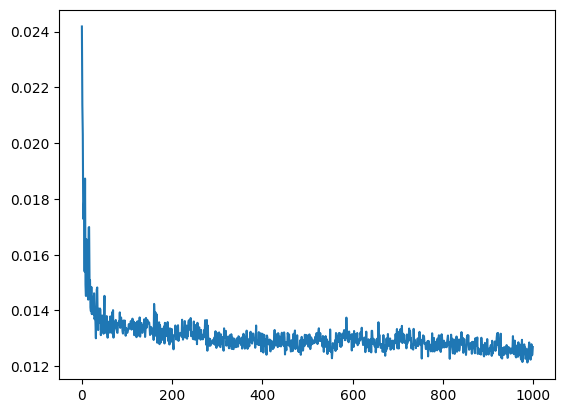

In [91]:
import matplotlib.pyplot as plt

train_loss = [train_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_loss = [valid_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
train_acc = [train_metric for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_acc = [valid_metric for train_loss, train_metric, valid_loss, valid_metric in trainer.history]

# plt.plot(range(len(train_loss)), train_loss)
# plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(valid_loss)), valid_loss)
# plt.plot(range(len(valid_acc)), valid_acc)